# Libraries

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

2023-11-22 10:23:19.246447: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-22 10:23:19.456144: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-11-22 10:23:19.456164: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-11-22 10:23:19.488716: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-22 10:23:20.377616: W tensorflow/stream_executor/platform/de

In [30]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Rescaling
from keras.models import Sequential
from keras.optimizers import Adam

from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

# Load data

Load it in grayscale.

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory('data/covid/train/', color_mode='grayscale', seed=42)
val_ds = tf.keras.utils.image_dataset_from_directory('data/covid/validation/', color_mode='grayscale', seed=42)
test_ds = tf.keras.utils.image_dataset_from_directory('data/covid/test/', color_mode='grayscale', seed=42)

Found 339 files belonging to 3 classes.
Found 42 files belonging to 3 classes.
Found 45 files belonging to 3 classes.


In [9]:
class_names = train_ds.class_names
class_names

['COVID-19', 'HEALTHY', 'PNEUMONIA']

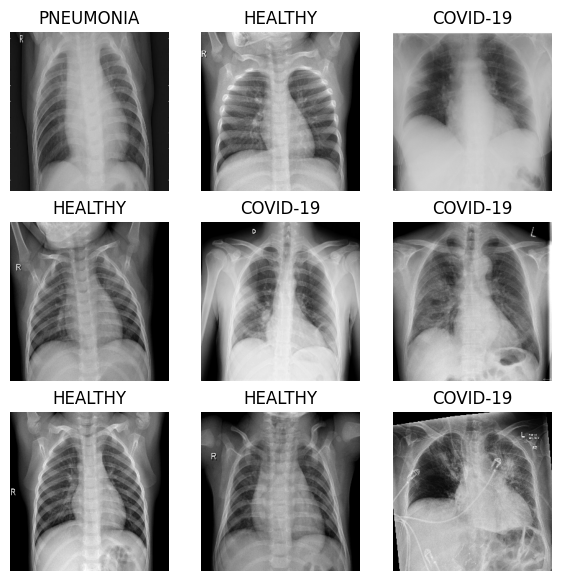

In [17]:
# Display image samples
plt.figure(figsize=(7, 7))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'), cmap='gray')
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [11]:
# Image shapes
images[i].shape

TensorShape([256, 256, 1])

# Classical ML

For working with classical ML algorithms we need some kind of matrix or DataFrame format for representing the features.

The function below transforms images to a pandas DataFrame.

In [ ]:
def get_images_df(image_dataset):
    # get images from dataset in DF format
    df = []
    all_labels = []
    for images, labels in image_dataset:
        for img in images:
            flat_img = tf.keras.preprocessing.image.img_to_array(img, data_format=None, dtype=None).flatten()
            df.append(flat_img)
        all_labels.extend(labels.numpy())
    df = pd.DataFrame(df)
    df['label'] = all_labels
    return df

In [ ]:
# Convert train, validation and test images to DF
df_train = get_images_df(train_ds)
df_val = get_images_df(val_ds)
df_test = get_images_df(test_ds)

In [23]:
print(df_train.shape)
df_train.head()

(339, 65537)


,0,1,2,3,4,5,6,7,8,9,...,65527,65528,65529,65530,65531,65532,65533,65534,65535,label
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.939125,12.074364,23.294922,36.796013,38.521873,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,22.958374,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
2,15.016342,7.648438,10.698578,12.588730,15.000000,9.667892,10.085938,11.148438,12.265625,13.775436,...,106.281601,83.865265,118.573334,179.406937,131.010361,118.155701,120.680328,79.302536,24.692123,1
3,0.000000,0.000000,0.000000,0.000000,0.234375,3.611328,6.611328,10.390625,16.109375,22.611328,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
4,3.218750,9.312500,15.093750,20.806641,24.207031,33.218750,42.673828,51.171875,53.314453,65.714844,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2


In [26]:
# We can subsample the train data to train faster
df_train_sub = df_train.sample(100, random_state=42)
X_train = df_train_sub.drop('label', axis=1)
y_train = df_train_sub['label']

X_val = df_val.drop('label', axis=1)
y_val = df_val['label']

X_test = df_test.drop('label', axis=1)
y_test = df_test['label']

## DT

In [19]:
from sklearn.tree import DecisionTreeClassifier

In [27]:
dt = DecisionTreeClassifier(max_depth=10)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10)

In [31]:
# Accuracy on validation set
y_val_pred = dt.predict(X_val)
accuracy_score(y_val, y_val_pred)

0.6190476190476191

In [34]:
class_names

['COVID-19', 'HEALTHY', 'PNEUMONIA']

In [35]:
labels

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([2, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 2, 0, 2, 2, 1, 2, 2, 2, 1, 1, 2,
       2, 1, 0, 0, 2, 2, 1, 0, 0, 1], dtype=int32)>

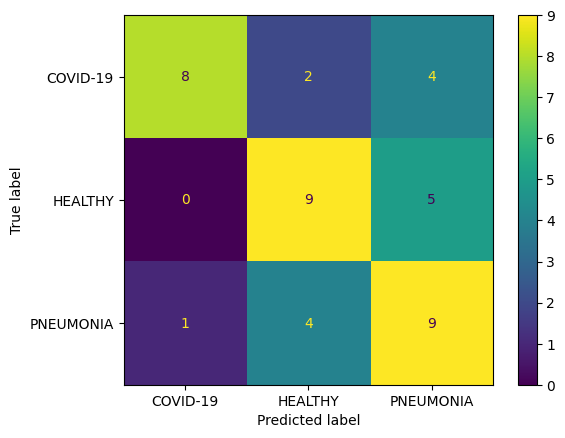

In [41]:
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred)
plt.xticks(range(3), class_names)
plt.yticks(range(3), class_names)
plt.show()

# CNN

Keras can directly load data from a structure of directories, we don't need the pandas DataFrame we were using before.

The following example is not working well. Improve it! For example, adding more convolutional layer and/or more filters, etc.

In [45]:
cnn_model = Sequential([
    Input(shape=(256, 256, 1)),
    Rescaling(1./255),
    Conv2D(filters=2, kernel_size=2, strides=1, activation='relu'),
    MaxPooling2D(pool_size=2, strides=None),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(len(class_names), activation='softmax')
])

cnn_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [46]:
cnn_model.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
11/11 [==============================] - 4s 206ms/step - loss: 4.3871 - accuracy: 0.3422 - val_loss: 1.0975 - val_accuracy: 0.3333
Epoch 2/5
11/11 [==============================] - 4s 187ms/step - loss: 1.0986 - accuracy: 0.3333 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 3/5
11/11 [==============================] - 4s 190ms/step - loss: 1.0986 - accuracy: 0.3333 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 4/5
11/11 [==============================] - 4s 197ms/step - loss: 1.0986 - accuracy: 0.3333 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 5/5
11/11 [==============================] - 4s 205ms/step - loss: 1.0986 - accuracy: 0.3333 - val_loss: 1.0986 - val_accuracy: 0.3333


In [47]:
loss, acc = cnn_model.evaluate(val_ds, verbose=0)
print('Validation accuracy:', round(acc, 2))

Validation accuracy: 0.33


In [52]:
# Keras returns predicted probabilities by default

y_val_pred_probs = cnn_model.predict(val_ds)
y_val_pred_probs[:5]

2/2 [==============================] - 0s 21ms/step


array([[0.3347708 , 0.33199838, 0.3332307 ],
       [0.3347708 , 0.33199838, 0.3332307 ],
       [0.3347708 , 0.33199838, 0.3332307 ],
       [0.3347708 , 0.33199838, 0.3332307 ],
       [0.3347708 , 0.33199838, 0.3332307 ]], dtype=float32)

In [55]:
# Convert probabilities to class predictions
y_val_pred = y_val_pred_probs.argmax(axis=1)
y_val_pred[:5]

array([0, 0, 0, 0, 0])

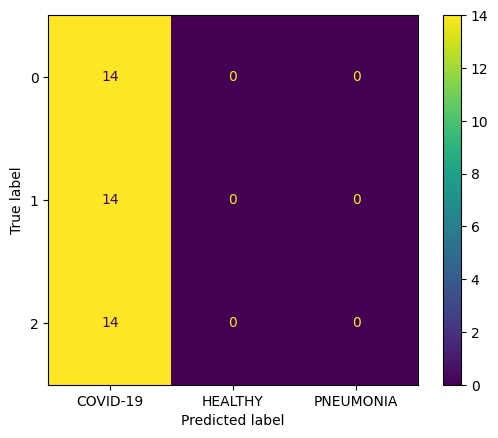

In [56]:
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred)
plt.xticks(range(3), val_ds.class_names)
plt.show()

# CNN RGB

Same example as before, but working with RGB images instead.

In this case, we just need to specify we are receiving an input of (256, 256, 3).

In [57]:
train_rgb_ds = tf.keras.utils.image_dataset_from_directory('data/covid/train/', seed=42)
val_rgb_ds = tf.keras.utils.image_dataset_from_directory('data/covid/validation/', seed=42)
test_rgb_ds = tf.keras.utils.image_dataset_from_directory('data/covid/test/', seed=42)

Found 339 files belonging to 3 classes.
Found 42 files belonging to 3 classes.
Found 45 files belonging to 3 classes.


In [66]:
cnn_model = Sequential([
    Input(shape=(256, 256, 3)),
    Rescaling(1./255),
    Conv2D(filters=3, kernel_size=2, strides=1, activation='relu'),
    MaxPooling2D(pool_size=2, strides=None),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(len(class_names), activation='softmax')
])

cnn_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [67]:
cnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 255, 255, 3)       39        
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 127, 127, 3)      0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 48387)             0         
                                                                 
 dense_10 (Dense)            (None, 32)                1548416   
                                                                 
 dense_11 (Dense)            (None, 3)                 99        
                                                      

In [68]:
cnn_model.fit(train_rgb_ds, validation_data=val_rgb_ds, epochs=2)

Epoch 1/2


11/11 [==============================] - 6s 313ms/step - loss: 1.6591 - accuracy: 0.5575 - val_loss: 0.6933 - val_accuracy: 0.6190
Epoch 2/2
11/11 [==============================] - 5s 254ms/step - loss: 0.4505 - accuracy: 0.8260 - val_loss: 0.6972 - val_accuracy: 0.6429


In [70]:
loss, acc = cnn_model.evaluate(val_rgb_ds, verbose=0)
print('Validation accuracy:', round(acc, 2))

Validation accuracy: 0.64
